# MXN442 Assignment 1
- Student Number: 10515402
- First Name: Aidan
- Last Name: Lockwood

## Assignment Setup
Installing required libraries

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ISLP import confusion_table
from ISLP.models import ModelSpec as MS, Stepwise, sklearn_selected, sklearn_selection_path, summarize

from sklearn.decomposition import PCA
import statsmodels.api as sm
import seaborn as sns

from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl
import sklearn.model_selection as skm

Loading required data

In [41]:
df = pd.read_csv('data/assignment1_data.csv')
df

,age,income,credit_score,years_employed,debt_to_income,num_credit_cards,education,marital_status,credit_limit,loan_default
0,52,25874.0,569,3.9,0.269,5,1,0,9131,0
1,43,NaN,613,0.1,0.059,5,0,1,9690,0
2,55,20000.0,578,18.3,0.088,2,2,1,15311,0
3,68,27887.0,663,6.0,0.182,3,3,0,13221,0
4,41,65268.0,794,15.2,0.162,3,3,0,24805,0
...,...,...,...,...,...,...,...,...,...,...
4995,44,102835.0,541,3.5,0.134,3,0,1,22262,0
4996,56,20000.0,798,NaN,0.288,3,2,1,8700,0
4997,80,20656.0,807,7.6,0.252,5,1,1,9876,0
4998,57,53993.0,544,3.4,0.422,2,1,1,8790,0


## Question 1: Linear Regression and Model Selection (12 Marks)

Banks need to set appropriate credit limits for customers based on their financial profiles. Setting limits too low may result in lost revenue opportunities, while setting them too high increases exposure to potential losses. The challenge is to develop a model that can accurately predict optimal credit limits using customer demographic, financial, and behavioural characteristics.

<b>a) Multiple Linear Regression (3 marks) </b>
- Handle missing values using mean imputation 
- Split data into training (70%) and test (30%) sets. Fit a multiple linear regression model using all features to predict `credit_limit` (1) 
- Interpret the coefficients of the three most significant predictors (1)

Handling the missing values using mean imputation

In [42]:
# Checking for the missing values in the dataset
data_columns = df.columns.to_list()

for column in data_columns:
    print(f'Column {column} has {df[column].isna().sum()} missing values')

Column age has 0 missing values
Column income has 150 missing values
Column credit_score has 0 missing values
Column years_employed has 150 missing values
Column debt_to_income has 0 missing values
Column num_credit_cards has 0 missing values
Column education has 0 missing values
Column marital_status has 0 missing values
Column credit_limit has 0 missing values
Column loan_default has 0 missing values


It appears that both `income` and `years_employed` have missing values. Thus the mean will be calculated for those values. The mean for each variable will be input into the NaN values

In [43]:
df['income'].mean()

np.float64(51458.36804123711)

In [44]:
# Calculating the mean values 
mean_income = round(df['income'].mean(), 2)
mean_years_employed = round(df['years_employed'].mean(), 2)

# Replacing the NaN values for each column with their respective means 
df['income'] = df['income'].fillna(mean_income)
df['years_employed'] = df['years_employed'].fillna(mean_years_employed)

# Checking the fill worked
for column in data_columns:
    print(f'Column {column} has {df[column].isna().sum()} missing values')

Column age has 0 missing values
Column income has 0 missing values
Column credit_score has 0 missing values
Column years_employed has 0 missing values
Column debt_to_income has 0 missing values
Column num_credit_cards has 0 missing values
Column education has 0 missing values
Column marital_status has 0 missing values
Column credit_limit has 0 missing values
Column loan_default has 0 missing values


The mean imputation has been completed.

Now time to split data into training and test splits, then generate a multiple linear regression model, fitting it to the training data.

In [45]:
df_size = df.shape[0]

training_size = int(df_size * 0.7)

training_data = df[0:training_size]
test_data = df[training_size:]

In [46]:
test_data

,age,income,credit_score,years_employed,debt_to_income,num_credit_cards,education,marital_status,credit_limit,loan_default
3500,63,269510.0,702,9.00,0.107,4,0,0,48686,0
3501,36,25303.0,678,2.70,0.628,1,2,0,2883,0
3502,46,165399.0,742,16.30,0.053,3,0,0,39412,0
3503,46,29421.0,715,11.00,0.039,3,1,1,14974,0
3504,37,20000.0,736,4.40,0.140,5,0,2,10242,0
...,...,...,...,...,...,...,...,...,...,...
4995,44,102835.0,541,3.50,0.134,3,0,1,22262,0
4996,56,20000.0,798,8.26,0.288,3,2,1,8700,0
4997,80,20656.0,807,7.60,0.252,5,1,1,9876,0
4998,57,53993.0,544,3.40,0.422,2,1,1,8790,0


Now to fit the data to a MLR.
Note that:
- `credit_limit` is the response variable

In [74]:
training_predictors = training_data.columns.drop(['credit_limit', 'loan_default'])

train_design = MS(training_predictors)
train_design = train_design.fit(training_data)

X = train_design.transform(training_data)
X

# Removing categorical variables from the scaling
X_train = X.drop(columns=['education', 'marital_status'])
X_train
# Experimenting with adjusting the scaling of the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled['education'] = training_data['education']
X_train_scaled['marital_status'] = training_data['marital_status']

X_train_scaled
Y = np.array(training_data['credit_limit'])
mlr_model = sm.OLS(Y, X)

results = mlr_model.fit()

results.summary()

## The result of standardising the X_train put the condition number to infinity
## Not standardising but adding all variables minus the response resulted in a large condition number

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 1.011e+04
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:50:29   Log-Likelihood:                -30984.
No. Observations:                3500   AIC:                         6.199e+04
Df Residuals:                    3491   BIC:                         6.204e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         1932.5195    215.203      8.980      0.000    1510.582    2354.457
age                 -0.7951      2.000     -0.398      0.691      -4.717       3.126
income               0.1510      0.001    251.816      0.000       0.150       0.152
credit_score         8.7822      0.253     34.746      0.000       8.287       9.278
years_employed     351.6655      3.620     97.145      0.000     344.568     358.763
debt_to_income    -1.49e+04    227.621    -65.461      0.000   -1.53e+04   -1.45e+04
num_credit_cards  -208.3009     16.542    -12.592      0.000    -240.734    -175.868
education          653.8239     29.630     22.066      0.000     595.729     711.918
marital_status     -31.3054     41.164     -0.761      0.447    -112.013      49.403
==============================================================================
Omnibus:                     4719.892   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2529235.562
Skew:                           7.253   Prob(JB):                         0.00
Kurtosis:                     133.893   Cond. No.                     6.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

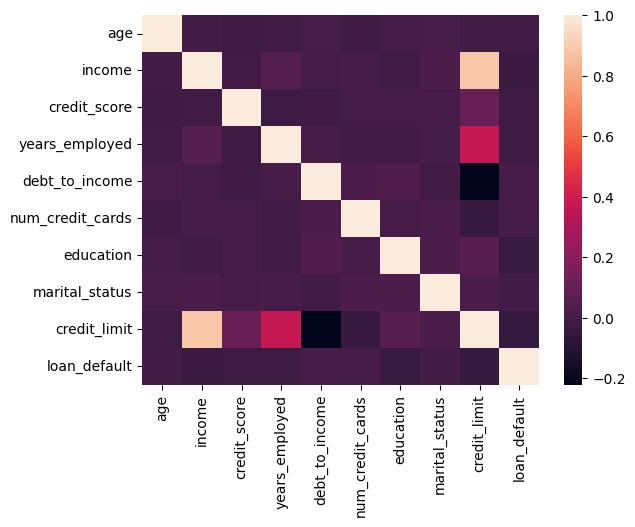

In [48]:
sns.heatmap(training_data.corr())

<b>b) Model Selection (4 marks)</b>
- Implement forward selection using AIC (1)
- Implement backward elimination using AIC (1)
- Compare the selected variables from both methods. Discuss which approach selects more variables and why (1)

Defining a Mallory Cp scoring function to help score the two models from forward and backward selection

In [49]:
def mallory_cp_scorer(sigma_2, estimator, X, Y):
    n, p = X.shape
    Y_hat = estimator.predict(X)
    RSS = np.sum((Y - Y_hat) ** 2)
    return -(RSS + 2 * p * sigma_2) / n

Y = np.array(training_data['credit_limit'])
X = train_design.transform(training_data)
sigma_2 = sm.OLS(Y, X).fit().scale


negative_cp = partial(mallory_cp_scorer, sigma_2)

Applying forward selection using AIC

In [ ]:
# Then defining the strategy to then fit to a linear regression task
forward_select_strategy = Stepwise.first_peak(train_design, 
                                              direction = 'forward',
                                              max_terms = len(train_design.terms))

# using sklearn_selected to fit a linear regression
forward_select_model = sklearn_selected(sm.OLS, 
                                        forward_select_strategy)

forward_select_model.fit(training_data, Y)
forward_select_model.selected_state_

('credit_score',
 'debt_to_income',
 'education',
 'income',
 'num_credit_cards',
 'years_employed')

In [51]:
full_path = sklearn_selection_path(sm.OLS, forward_select_strategy)

full_path.fit(training_data, training_data['credit_limit'])
Y_hat_in = full_path.predict(training_data)
Y_hat_in.shape

(3500, 9)

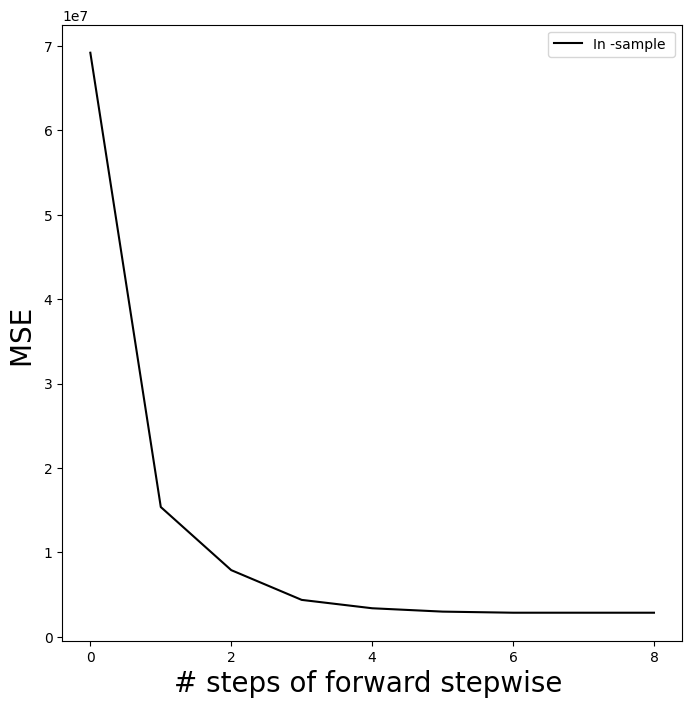

In [52]:
mse_fig , ax = plt.subplots (figsize =(8 ,8))
insample_mse = (( Y_hat_in - Y[:, None ]) **2).mean (0)
n_steps = insample_mse .shape [0]
ax.plot(np.arange(n_steps),
insample_mse ,
'k', # color black
label='In -sample ')
ax. set_ylabel ('MSE ',
fontsize =20)
ax. set_xlabel ('# steps of forward stepwise ',
fontsize =20)
ax. set_xticks (np.arange(n_steps)[::2])
ax.legend ()

Applying backward elimination with AIC

In [53]:
backward_select_strategy = Stepwise.first_peak(train_design,
                                               direction = 'backwards',
                                               max_terms = len(train_design.terms))

backward_select_model = sklearn_selected(sm.OLS,
                                         backward_select_strategy,
                                         scoring = negative_cp)

backward_select_model.fit(training_data, training_data['credit_limit'])
backward_select_model.selected_state_

('credit_score',
 'debt_to_income',
 'education',
 'income',
 'num_credit_cards',
 'years_employed')

In [54]:
full_path = sklearn_selection_path(sm.OLS, backward_select_strategy)

full_path.fit(training_data, training_data['credit_limit'])
Y_hat_in = full_path.predict(training_data)
Y_hat_in.shape

(3500, 10)

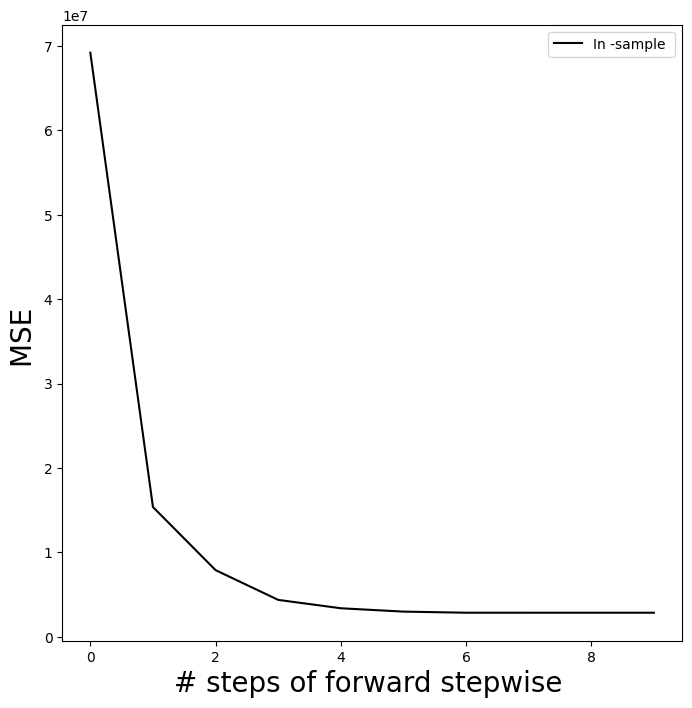

In [55]:
mse_fig , ax = plt.subplots (figsize =(8 ,8))
insample_mse = (( Y_hat_in - Y[:, None ]) **2).mean (0)
n_steps = insample_mse.shape [0]
ax.plot(np.arange(n_steps),
insample_mse ,
'k', # color black
label='In -sample ')
ax. set_ylabel ('MSE ',
fontsize =20)
ax. set_xlabel ('# steps of forward stepwise ',
fontsize =20)
ax. set_xticks (np.arange(n_steps)[::2])
ax.legend ()

WANTING TO DEBUG THIS... DOESN'T LOOK RIGHT

In [56]:
backward_select_model.selected_state_ == forward_select_model.selected_state_

True

Compare the selected variables from both methods. Discuss which approach selects more variables and why?

In [57]:
## Plot RMSE and discuss the approaches and variables


<b>c) Regularisation (5 marks)</b>
- Implement Ridge and Lasso Regression with 5-fold cross validation (2)
- Plot the cross-validation error vs lambda for both methods (1)
- Calculate test set RMSE for all five models (full, forward, backward, Ridge, Lasso) (2)

Implementing Ridge and Lasso Regression with 5-fold cross-validation

In [58]:
# Setting the k_fold cross-validation 
K = 5
kfold = skm.KFold(n_splits = K)
Y_hat_cv = skm.cross_val_predict(skl.LinearRegression(), X = X, y = Y[:, None], cv = kfold)
Y_hat_cv.shape

(3500, 1)

In [59]:
# Setting the Lambda values to find optimal performance
lambdas = 10 ** np.linspace(8, -2, 100) / Y.std()

Xs = X

In [60]:
# Generating the Ridge Model
ridge_model = skl.ElasticNet(alpha = lambdas[60], l1_ratio = 0)
ridge_scaler = StandardScaler(with_mean = True, with_std = True)
ridge_pipeline = Pipeline(steps = [('scaler', ridge_scaler), ('ridge', ridge_model)])
ridge_pipeline.fit(X, Y)

/Users/aidanlockwood/Documents/GitHub/MXN442-Codebase/mxn442_venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.185e+09, tolerance: 2.421e+07
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(0....7760647861275)
,l1_ratio,0
,fit_intercept,True
,precompute,False


In [61]:
np.linalg.norm(ridge_model.coef_)

np.float64(7977.633946272427)

In [62]:
# Generating the Lasso Regression Model
lasso_model = skl.ElasticNet(alpha = lambdas[60], l1_ratio = 1)
lasso_scaler = StandardScaler(with_mean = True, with_std = True)
lasso_pipeline = Pipeline(steps = [('scaler', lasso_scaler), ('lasso', lasso_model)])
lasso_pipeline.fit(X, Y)

,steps,"[('scaler', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(0....7760647861275)
,l1_ratio,1
,fit_intercept,True
,precompute,False


In [63]:
np.linalg.norm(lasso_model.coef_)

np.float64(8059.55926885886)

## Question 2: Dimension Reduction (8 marks)

<b>a) Principal Component Analysis (4 marks)</b>
- Perform PCA on the numerical features (age, income, credit_score, years_employed, debt_to_income, num_credit_cards) (1)
- Determine how many components explain 90% of the variance (1)
- Interpret the first two principal components by examining their loadings (1)
- Create a scatter plot of the first two principal components (1)

Performing PCA on the numerical features of the data

In [64]:
training_data

,age,income,credit_score,years_employed,debt_to_income,num_credit_cards,education,marital_status,credit_limit,loan_default
0,52,25874.00,569,3.9,0.269,5,1,0,9131,0
1,43,51458.37,613,0.1,0.059,5,0,1,9690,0
2,55,20000.00,578,18.3,0.088,2,2,1,15311,0
3,68,27887.00,663,6.0,0.182,3,3,0,13221,0
4,41,65268.00,794,15.2,0.162,3,3,0,24805,0
...,...,...,...,...,...,...,...,...,...,...
3495,74,65713.00,682,8.4,0.372,3,1,1,14890,0
3496,57,55735.00,478,22.6,0.023,4,2,1,21713,0
3497,44,95531.00,804,10.0,0.047,7,1,2,25524,0
3498,42,20000.00,665,12.7,0.069,1,2,0,14406,0


In [65]:
q2_data = test_data.drop(columns = ['education', 'marital_status', 'loan_default'])
q2_data = np.asarray(q2_data)
q2_data

array([[6.30000e+01, 2.69510e+05, 7.02000e+02, ..., 1.07000e-01,
        4.00000e+00, 4.86860e+04],
       [3.60000e+01, 2.53030e+04, 6.78000e+02, ..., 6.28000e-01,
        1.00000e+00, 2.88300e+03],
       [4.60000e+01, 1.65399e+05, 7.42000e+02, ..., 5.30000e-02,
        3.00000e+00, 3.94120e+04],
       ...,
       [8.00000e+01, 2.06560e+04, 8.07000e+02, ..., 2.52000e-01,
        5.00000e+00, 9.87600e+03],
       [5.70000e+01, 5.39930e+04, 5.44000e+02, ..., 4.22000e-01,
        2.00000e+00, 8.79000e+03],
       [3.20000e+01, 6.08100e+04, 6.32000e+02, ..., 3.80000e-02,
        4.00000e+00, 1.66160e+04]], shape=(1500, 7))

In [66]:
pca = PCA(n_components = 2)
linear_regression = skl.LinearRegression()
pipeline = Pipeline([('scaler', lasso_scaler),
                     ('pca', pca),
                     ('linear_regression', linear_regression)])

pipeline.fit(q2_data, np.array(test_data['credit_limit']))

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'


/Users/aidanlockwood/Documents/GitHub/MXN442-Codebase/mxn442_venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
50 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aidanlockwood/Documents/GitHub/MXN442-Codebase/mxn442_venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aidanlockwood/Documents/GitHub/MXN442-Codebase/mxn442_venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^

(50000.0, 250000.0)

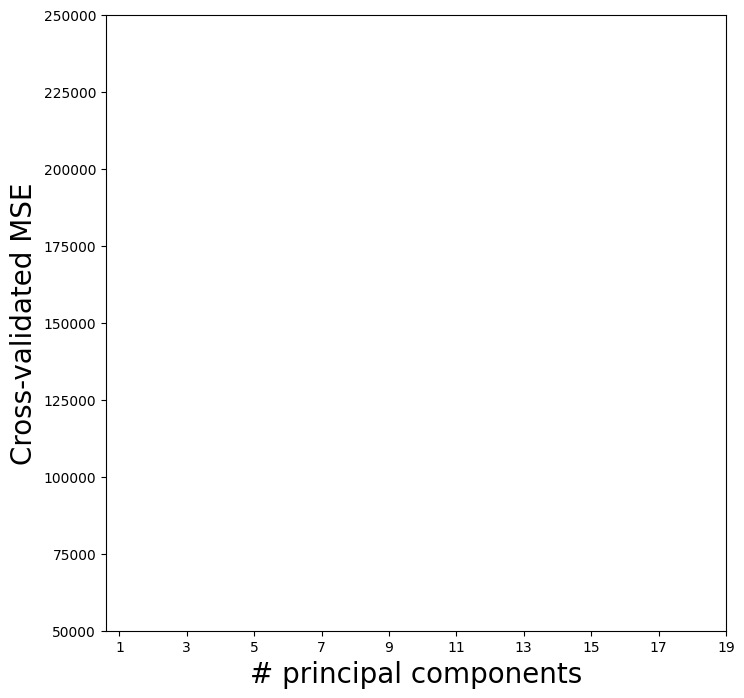

In [67]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipeline,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

pcr_fig, ax = plt.subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000])

<b>b) PCR and PLS Comparison (4 marks)</b>
- Implement Principal Component Regression (PCR) using cross-validation (1)
- Implement Partial Least Squares (PLS) regression using cross-validation (1)
- Plot cross-validation error vs number of components for both methods (1)
- Compare PCR and PLS test performances with your best model from Question 1 (1)

## Question 3: Classification (10 marks)

Identifying customers likely to default on their loans is essential for risk management. Early identification allows banks to take preventative measures, adjust terms, or decline high-risk applications. This requires building classification models that can distinguish between customers who will successfully repay loans and those who may default.

<b>a) Logistic Regression (4 marks)</b>
- Fit a logistic regression model to predict `loan_default` (2)
- Calculate accuracy, precision, recall, and F1-score on the test set (1)
- Create an ROC curve and report the AUC (1)

In [68]:
q3_variables = training_data.columns.drop(['loan_default'])

q3_design = MS(q3_variables)

X = q3_design.fit_transform(training_data)
Y = np.array(training_data['loan_default'])


glm = sm.GLM(Y, X, family=sm.families.Binomial())
results = glm.fit()

In [69]:
probabilities = results.predict()
probabilities

array([0.01325329, 0.01389585, 0.00276827, ..., 0.00077986, 0.0031934 ,
       0.00052419], shape=(3500,))

<b>b) Linear Discriminant Analysis (4 marks)</b>
- Implement Linear Discriminant Analysis (LDA) for the classification problem (2)
- Compare LDA performance with logistic regression using the same metrics (1)
- Create a confusion matrix for LDA predictions (1)

<b>c) Model Comparison (2 marks)</b>
- Create a summary table comparing two classification methods (1)
- Discuss which method performs best and provide any insights you could (1)